# Predict Power generation #plant_1

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">navigation</h3>

* [1. Library](#1)
* [2. Data reading](#2)
* [3. Preprocessing](#3)
* [4. Identify Faulty SOURCE_KEY](#4)
* [5. Identify Faulty dust](#5)
* [6. Model build](#6)
* [7. Predict next two day generation](#7)


<a id="1"></a>

# Library

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/.DS_Store
../input/heart.csv
../input/iris/Iris.csv
../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv
../input/classification-suv-dataset/Social_Network_Ads.csv
../input/wine-reviews/.DS_Store
../input/wine-reviews/winemag-data-130k-v2.csv
../input/wine-reviews/winemag-data-130k-v2.json
../input/wine-reviews/winemag-data_first150k.csv
../input/random-linear-regression/test.csv
../input/random-linear-regression/train.csv
../input/solar-power-generation-data/Plant_2_Generation_Data.csv
../input/solar-power-generation-data/Plant_1_Generation_Data.csv
../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
../input/svm-classification/SVM_Classification.R
../input/svm-classification/UniversalBank.csv
../input/svm-classification/Activity Sheet.docx
../input/house-prices-advanced-regression-techniques/test.csv
../input/house-prices-advanced-regression-techniques/data_description.txt
.

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split

<a id="2"></a>

# Data reading

In [3]:
plant_df = pd.read_csv("../input/solar-power-generation-data/Plant_1_Generation_Data.csv")
plant_df.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [4]:
plant_df.shape

(68778, 7)

In [5]:
plant_df_columns = plant_df.columns.tolist()
plant_df[plant_df_columns].isnull().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

<a id="3"></a>

# Preprocessing

In [6]:
plant_df['DATE_TIME']= pd.to_datetime(plant_df['DATE_TIME'],format='%d-%m-%Y %H:%M') 

In [7]:
SOURCE_KEY_list = plant_df['SOURCE_KEY'].unique()
day_of_month_list = plant_df['DATE_TIME'].dt.day.unique()
month_list = plant_df['DATE_TIME'].dt.month.unique()

In [8]:
def data_collection():
    main_df = pd.DataFrame()
    for i in day_of_month_list:
        for j in month_list:
            df=plant_df[(plant_df.DATE_TIME.dt.month == j) & (plant_df.DATE_TIME.dt.day == i) ][-len(SOURCE_KEY_list):]
            df = df.drop(['PLANT_ID', 'DC_POWER', 'AC_POWER', 'TOTAL_YIELD'],axis = 1)
            df = df[df.DAILY_YIELD != 0]
            main_df = main_df.append(df, ignore_index=True)
    return main_df
main_df = data_collection()

In [9]:
main_df.index = main_df.DATE_TIME.dt.date.astype("datetime64[ns]")
main_df = main_df.drop(["DATE_TIME"],axis=1)

<a id="4"></a>

# Identify Faulty SOURCE_KEY

**Easily Identify faulty inverter side with graph of daily power generation.**

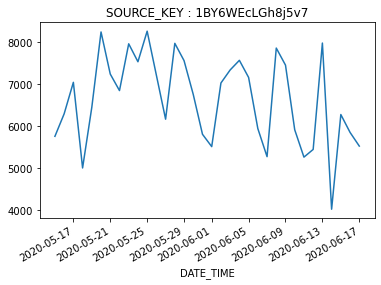

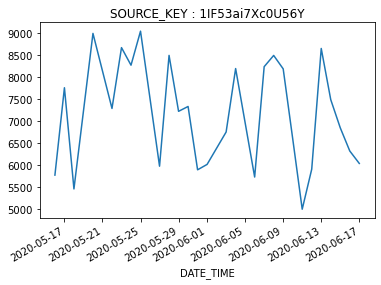

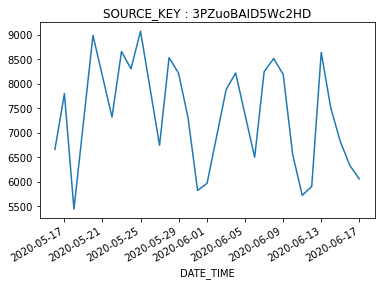

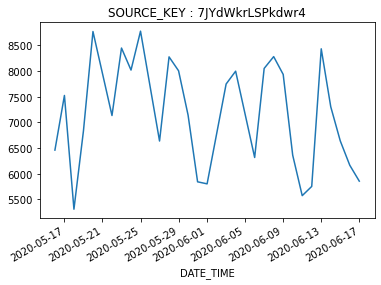

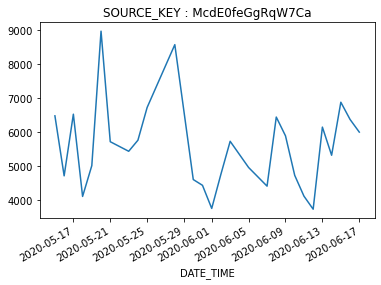

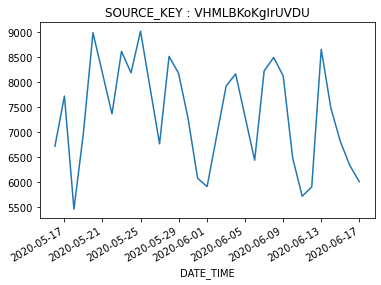

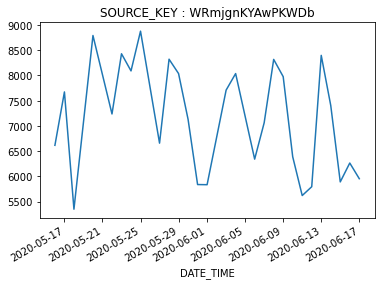

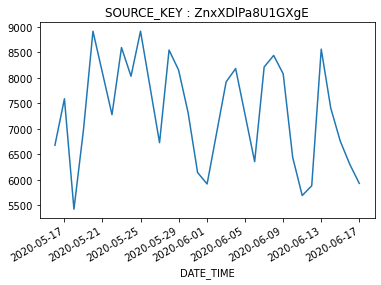

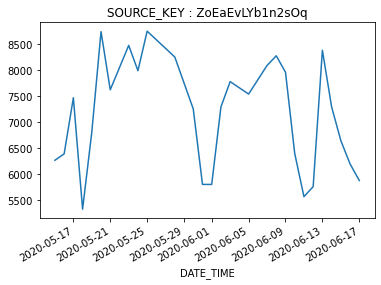

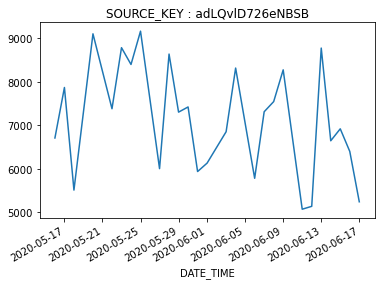

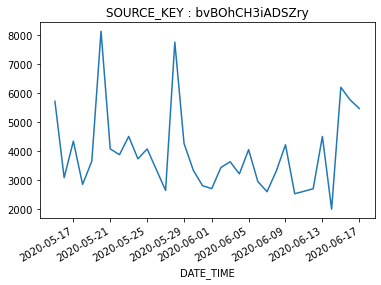

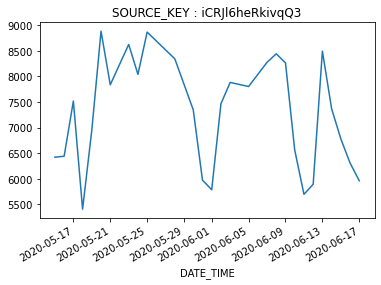

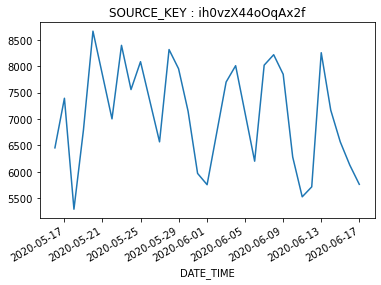

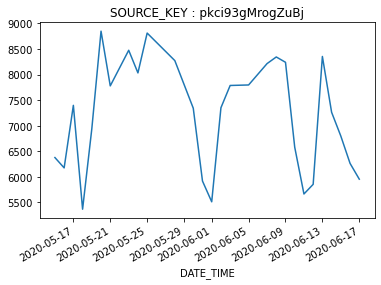

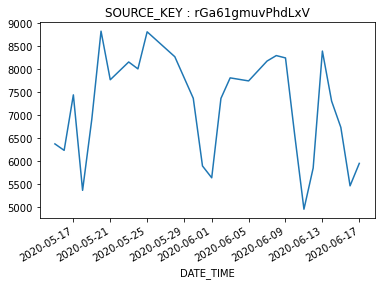

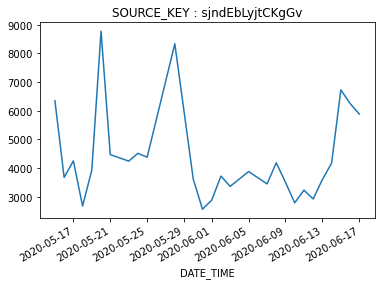

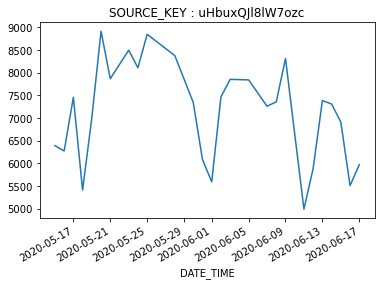

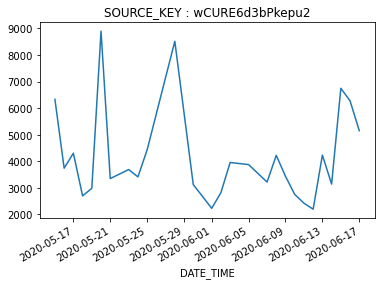

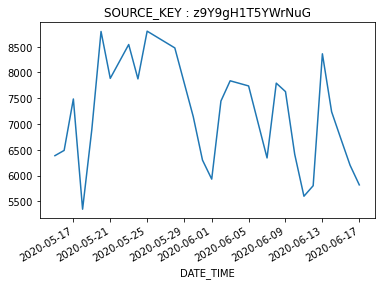

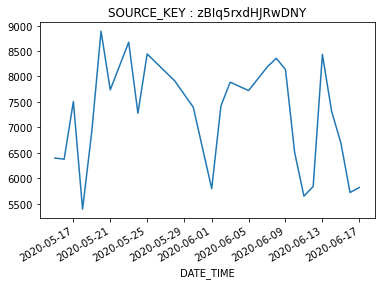

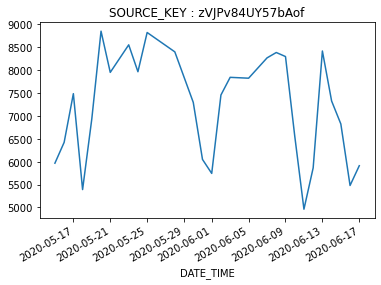

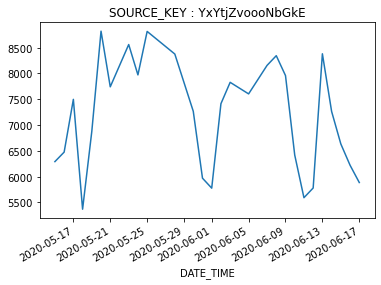

In [10]:
for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
    plt.title("SOURCE_KEY : %s"%i)
    plt.show()

**Can see some line suddenly drop down in below graph?**

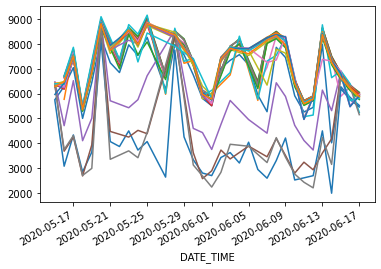

In [11]:

for i in SOURCE_KEY_list:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
plt.show()

This is faulty inverter ID list  (Fault_SOURCE_KEY_list)

In [12]:
Fault_SOURCE_KEY_list=  ["McdE0feGgRqW7Ca","bvBOhCH3iADSZry","sjndEbLyjtCKgGv","wCURE6d3bPkepu2"]

In [13]:
#remove data who having Fault_SOURCE_KEY_list in main_df
for i in Fault_SOURCE_KEY_list:
    main_df = main_df[main_df.SOURCE_KEY != i]

<a id="5"></a>

# Identify Faulty dust

in below graph just increase irregularities with time is some other faulty like DUST and others

<function matplotlib.pyplot.show(*args, **kw)>

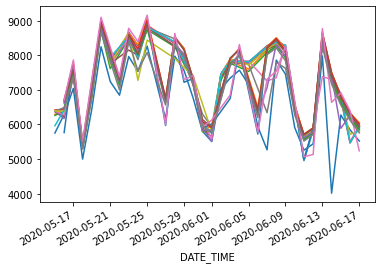

In [14]:
Unfault_SOURCE_KEY = main_df.SOURCE_KEY.unique()
for i in Unfault_SOURCE_KEY:
    df = main_df[main_df.SOURCE_KEY == i]
    df.DAILY_YIELD.plot()
plt.show

<a id="6"></a>

# Model build

In [15]:
main_df['dayofweek'] = main_df.index.dayofweek
main_df['quarter'] = main_df.index.quarter
main_df['month'] = main_df.index.month
main_df['year'] = main_df.index.year
main_df['dayofyear'] = main_df.index.dayofyear
main_df['dayofmonth'] = main_df.index.day
main_df['weekofyear'] = main_df.index.weekofyear

In [16]:
label_encoder = preprocessing.LabelEncoder() 
main_df['SOURCE_KEY']= label_encoder.fit_transform(main_df['SOURCE_KEY']) 
X = main_df[['SOURCE_KEY','dayofweek', 'quarter','month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = main_df["DAILY_YIELD"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

In [17]:
reg = xgb.XGBRegressor(n_estimators=500,
                       objective ='reg:squarederror',
                       learning_rate = 0.16,
                       colsample_bytree=0.6,
                       max_depth = 5,
                       min_child_weight = 6)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50)

[0]	validation_0-rmse:6077.89502	validation_1-rmse:6316.83740
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5131.98828	validation_1-rmse:5368.24707
[2]	validation_0-rmse:4335.25195	validation_1-rmse:4541.08691
[3]	validation_0-rmse:3673.22168	validation_1-rmse:3868.24097
[4]	validation_0-rmse:3121.63696	validation_1-rmse:3300.86060
[5]	validation_0-rmse:2649.54907	validation_1-rmse:2817.26782
[6]	validation_0-rmse:2250.88599	validation_1-rmse:2402.76636
[7]	validation_0-rmse:1920.49475	validation_1-rmse:2052.38403
[8]	validation_0-rmse:1654.11890	validation_1-rmse:1774.87732
[9]	validation_0-rmse:1416.20960	validation_1-rmse:1530.84924
[10]	validation_0-rmse:1235.64380	validation_1-rmse:1338.49036
[11]	validation_0-rmse:1073.62549	validation_1-rmse:1159.66174
[12]	validation_0-rmse:954.91681	validation_1-rmse:1029.19898
[13]	validation_0-rmse:833.95850	

[131]	validation_0-rmse:185.09363	validation_1-rmse:242.14970
[132]	validation_0-rmse:184.15700	validation_1-rmse:241.54059
[133]	validation_0-rmse:184.11615	validation_1-rmse:241.81486
[134]	validation_0-rmse:184.08571	validation_1-rmse:242.09291
[135]	validation_0-rmse:183.49992	validation_1-rmse:241.07487
[136]	validation_0-rmse:182.72089	validation_1-rmse:242.22467
[137]	validation_0-rmse:182.70241	validation_1-rmse:242.48271
[138]	validation_0-rmse:182.68720	validation_1-rmse:242.69815
[139]	validation_0-rmse:182.68007	validation_1-rmse:242.85170
[140]	validation_0-rmse:182.18837	validation_1-rmse:241.90373
[141]	validation_0-rmse:181.01254	validation_1-rmse:240.34518
[142]	validation_0-rmse:180.40645	validation_1-rmse:239.98379
[143]	validation_0-rmse:179.70360	validation_1-rmse:239.08812
[144]	validation_0-rmse:179.65442	validation_1-rmse:239.34845
[145]	validation_0-rmse:179.61797	validation_1-rmse:239.54596
[146]	validation_0-rmse:179.20171	validation_1-rmse:240.14795
Stopping

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.16, max_delta_step=0, max_depth=5,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

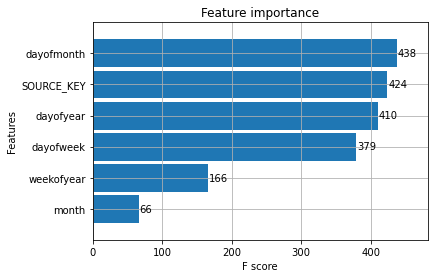

In [18]:
plot_importance(reg, height=0.9)

In [19]:
y_pred = reg.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

238.89289019591638

<a id="7"></a>

# Predict next two day generation

this model is not effective for predict for greater then 5 days because of we have only 34 days data.

In [20]:
# n = number of days to predict future generation
def create_df(n):
    prediction_df = pd.DataFrame()
    for i in range(0,n):
        df = pd.DataFrame()
        df["SOURCE_KEY"] = Unfault_SOURCE_KEY
        df["DATE_TIME"] = "2020-06-%d"%(i+15)
        prediction_df = prediction_df.append(df)
    prediction_df['DATE_TIME']= pd.to_datetime(prediction_df['DATE_TIME']) 
    prediction_df.index = prediction_df.DATE_TIME.dt.date.astype("datetime64[ns]")
    prediction_df = prediction_df.drop(["DATE_TIME"],axis=1)
    prediction_df['dayofweek'] = prediction_df.index.dayofweek
    prediction_df['quarter'] = prediction_df.index.quarter
    prediction_df['month'] = prediction_df.index.month
    prediction_df['year'] = prediction_df.index.year
    prediction_df['dayofyear'] = prediction_df.index.dayofyear
    prediction_df['dayofmonth'] = prediction_df.index.day
    prediction_df['weekofyear'] = prediction_df.index.week
    return prediction_df
        

In [21]:
x = create_df(2)
df_copy = x.copy() 
x['SOURCE_KEY'] = label_encoder.fit_transform(x['SOURCE_KEY'])


In [22]:
y_prediction = reg.predict(x)

In [23]:
df_copy["DAILY_YIELD_prediction"] = y_prediction

In [24]:
df_copy

SOURCE_KEY  dayofweek  quarter  month  year  dayofyear  \
DATE_TIME                                                                 
2020-06-15  1BY6WEcLGh8j5v7          0        2      6  2020        167   
2020-06-15  YxYtjZvoooNbGkE          0        2      6  2020        167   
2020-06-15  ZoEaEvLYb1n2sOq          0        2      6  2020        167   
2020-06-15  iCRJl6heRkivqQ3          0        2      6  2020        167   
2020-06-15  pkci93gMrogZuBj          0        2      6  2020        167   
2020-06-15  rGa61gmuvPhdLxV          0        2      6  2020        167   
2020-06-15  uHbuxQJl8lW7ozc          0        2      6  2020        167   
2020-06-15  z9Y9gH1T5YWrNuG          0        2      6  2020        167   
2020-06-15  zBIq5rxdHJRwDNY          0        2      6  2020        167   
2020-06-15  zVJPv84UY57bAof          0        2      6  2020        167   
2020-06-15  1IF53ai7Xc0U56Y          0        2      6  2020        167   
2020-06-15  3PZuoBAID5Wc2HD          0        2      6  2020        167   
2020-06-15  7JYdWkrLSPkdwr4          0        2      6  2020        167   
2020-06-15  VHMLBKoKgIrUVDU          0        2      6  2020        167   
2020-06-15  WRmjgnKYAwPKWDb          0        2      6  2020        167   
2020-06-15  ZnxXDlPa8U1GXgE          0        2      6  2020        167   
2020-06-15  adLQvlD726eNBSB          0        2      6  2020        167   
2020-06-15  ih0vzX44oOqAx2f          0        2      6  2020        167   
2020-06-16  1BY6WEcLGh8j5v7          1        2      6  2020        168   
2020-06-16  YxYtjZvoooNbGkE          1        2      6  2020        168   
2020-06-16  ZoEaEvLYb1n2sOq          1        2      6  2020        168   
2020-06-16  iCRJl6heRkivqQ3          1        2      6  2020        168   
2020-06-16  pkci93gMrogZuBj          1        2      6  2020        168   
2020-06-16  rGa61gmuvPhdLxV          1        2      6  2020        168   
2020-06-16  uHbuxQJl8lW7ozc          1        2      6  2020        168   
2020-06-16  z9Y9gH1T5YWrNuG          1        2      6  2020        168   
2020-06-16  zBIq5rxdHJRwDNY          1        2      6  2020        168   
2020-06-16  zVJPv84UY57bAof          1        2      6  2020        168   
2020-06-16  1IF53ai7Xc0U56Y          1        2      6  2020        168   
2020-06-16  3PZuoBAID5Wc2HD          1        2      6  2020        168   
2020-06-16  7JYdWkrLSPkdwr4          1        2      6  2020        168   
2020-06-16  VHMLBKoKgIrUVDU          1        2      6  2020        168   
2020-06-16  WRmjgnKYAwPKWDb          1        2      6  2020        168   
2020-06-16  ZnxXDlPa8U1GXgE          1        2      6  2020        168   
2020-06-16  adLQvlD726eNBSB          1        2      6  2020        168   
2020-06-16  ih0vzX44oOqAx2f          1        2      6  2020        168   

            dayofmonth  weekofyear  DAILY_YIELD_prediction  
DATE_TIME                                                   
2020-06-15          15          25             6018.544434  
2020-06-15          15          25             6661.554688  
2020-06-15          15          25             6668.190430  
2020-06-15          15          25             6796.176758  
2020-06-15          15          25             6737.136230  
2020-06-15          15          25             6677.058105  
2020-06-15          15          25             6688.008789  
2020-06-15          15          25             6694.371094  
2020-06-15          15          25             6682.435547  
2020-06-15          15          25             6645.650391  
2020-06-15          15          25             6755.283203  
2020-06-15          15          25             6810.164062  
2020-06-15          15          25             6656.351074  
2020-06-15          15          25             6780.166992  
2020-06-15          15          25             6596.462891  
2020-06-15          15          25             6741.468262  
2020-06-15          15          25             6661.522461  
2020-06

# Please comment for any idea to get improvment of model also, Write comment for mistakes